pygame 2.5.1 (SDL 2.28.2, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
<Group(2 sprites)>


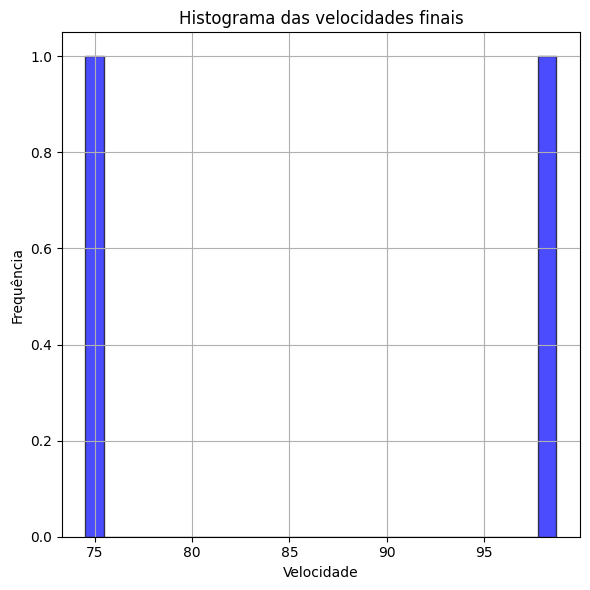

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
#Debugging 10-10-2023
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid - logic
#Colisões e previsão funcionam + grid (inherited 6.10)
#Colisão inelástica e elástica implementada
#Colisão 'no future' mantida por causa de stuttering no pygame
#Colisão futura implementada em classe Particula
#Fazer: reação química


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 2
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

# Indexes de moléculas das reações
NA_CL_INDEX = 0

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = float(x_future)
        self.y_future = float(y_future)
        self.cor = cor

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

        # Colisao parede
        if self.x < self.raio or self.x > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=TIPO_COLISAO)

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if ((distance <= p1.raio + p2.raio) or (distance_future <= p1.raio + p2.raio)) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    #print('arrays_reaction_CM:', CM_x, CM_y )

    new_particles = particles.copy()
    print('old_new_particles:', new_particles)
    #print(p1.p_type, p2.p_type)

    if (p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na'):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = massa
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        x_future = x + vel_x * DT * FUTURE_FACTOR
        y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor)
        NA_CL_INDEX += 1

        new_particles.update({nome_particula : particle_instance})
        new_particles.pop(p1_index)
        new_particles.pop(p2_index)


    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    print('new_new_particles:',new_particles)
    return new_particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula

def iterar_reaction(particles):
    for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    new_particles = reaction_collision(particles,particle_instance,particle_name,other_particle_instance,other_particle_name)
                    iterar_reaction(new_particles)


def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        x_future = x + vel_x * DT * FUTURE_FACTOR
        y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor)
        particulas[nome_particula] = particle_instance

    return particulas


def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        circle = pygame.Surface((particle_instance.raio * 2, particle_instance.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, particle_instance.cor, (particle_instance.raio, particle_instance.raio), particle_instance.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(particle_instance.x, particle_instance.y))
        sprites.add(sprite)
    print(sprites)
    return sprites


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_sprites(particles)

    grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_11.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        # Resolve collisions after updating positions
        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    resolve_collision(particle_instance, other_particle_instance, collision_type=TIPO_COLISAO)

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


In [13]:
#Debugging 10-10-2023 == TRUE_v1
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid - logic
#Colisões e previsão funcionam + grid (inherited 6.10)
#Colisão inelástica e elástica implementada
#Colisão 'no future' mantida por causa de stuttering no pygame
#Colisão futura implementada em classe Particula
#Fazer: reação química


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 2
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

# Indexes de moléculas das reações
NA_CL_INDEX = 0

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

        # Colisao parede
        if self.x < self.raio or self.x > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite


class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=TIPO_COLISAO)

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if ((distance <= p1.raio + p2.raio) or (distance_future <= p1.raio + p2.raio)) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    #print('arrays_reaction_CM:', CM_x, CM_y )

    new_particles = particles.copy()
    print('old_new_particles:', new_particles)
    #print(p1.p_type, p2.p_type)

    if (p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na'):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = massa
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor)
        NA_CL_INDEX += 1

        sprites.kill(p1)

        new_particles.update({nome_particula : particle_instance})
        new_particles.pop(p1_index)
        new_particles.pop(p2_index)


    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    print('new_new_particles:',new_particles)
    return new_particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula

def iterar_reaction(particles):
    for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    new_particles = reaction_collision(particles,particle_instance,particle_name,other_particle_instance,other_particle_name)
                    iterar_reaction(new_particles)


def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas


def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    print(sprites)
    return sprites


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_11.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        # Resolve collisions after updating positions
        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    reaction_collision(particles,particle_instance,particle_name, other_particle_instance,other_particle_name)

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


<Group(2 sprites)>


TypeError: reaction_collision() missing 1 required positional argument: 'sprites'

<Group(2 sprites)>


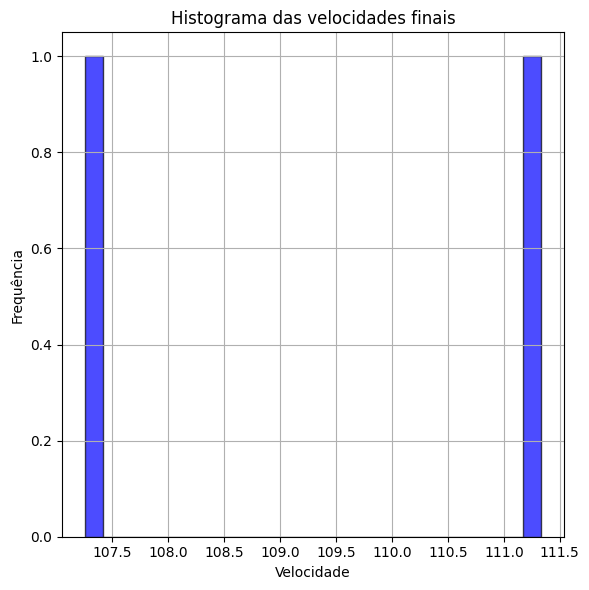

SystemExit: 

In [3]:
#Debugging 10-10-2023 == TRUE_v2
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid - logic
#Colisões e previsão funcionam + grid (inherited 6.10)
#Colisão inelástica e elástica implementada
#Colisão 'no future' mantida por causa de stuttering no pygame
#Colisão futura implementada em classe Particula
#Fazer: reação química


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 2
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

# Indexes de moléculas das reações
NA_CL_INDEX = 0

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite


class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=TIPO_COLISAO)

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    print('old_particles:', particles)
    #print(p1.p_type, p2.p_type)

    if (p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na'):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = massa
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()



    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    print('new_particles:',particles)
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula

def iterar_reaction(particles):
    for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    new_particles = reaction_collision(particles,particle_instance,particle_name,other_particle_instance,other_particle_name)
                    iterar_reaction(new_particles)


def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas


def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    print(sprites)
    return sprites


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_11.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        # Resolve collisions after updating positions
        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    reaction_collision(particles,particle_instance,particle_name, other_particle_instance,other_particle_name,sprites)

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


<Group(2 sprites)>
old_particles: {'Na_1': <__main__.Particula object at 0x00000213D8474040>, 'Cl_2': <__main__.Particula object at 0x00000213D83B7670>}
new_particles: {'NaCl_0': <__main__.Particula object at 0x00000213E9D9FB20>}
funciona


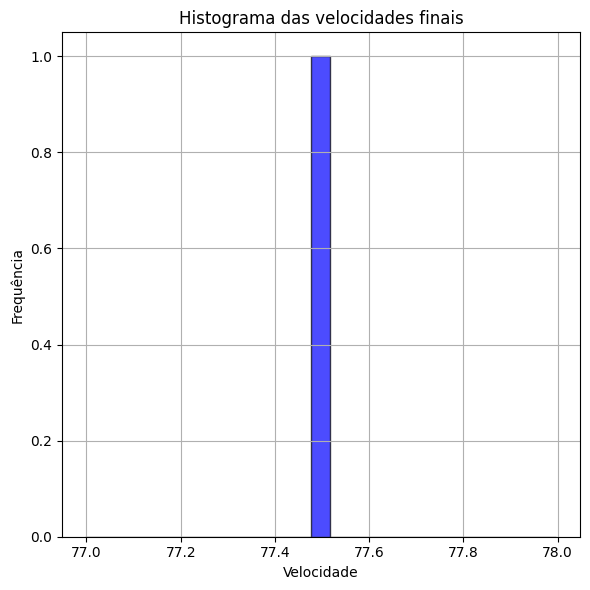

SystemExit: 

In [6]:
#Debugging 12-10-2023 == TRUE_v3; LATEST STABLE == V2
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid - logic
#Colisões e previsão funcionam + grid (inherited 6.12)
#Colisão inelástica e elástica implementada
#Colisão 'no future' mantida por causa de stuttering no pygame
#Colisão futura implementada em classe Particula
#Fazer: reação química; remoção dos reagentes implementado + minor optimizations


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 2
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

# Indexes de moléculas das reações
NA_CL_INDEX = 0

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite


class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=TIPO_COLISAO)

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    print('old_particles:', particles)
    #print(p1.p_type, p2.p_type)

    if (p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na'):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = massa
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()



    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    print('new_particles:',particles)
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula

def iterar_reaction(particles):
    for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    new_particles = reaction_collision(particles,particle_instance,particle_name,other_particle_instance,other_particle_name)
                    iterar_reaction(new_particles)


def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas

def select_particles(particles):
    particles_to_update = set()
    particles_to_remove = []

    particle_pairs = list(itertools.combinations(particles.items(), 2))

    for (name1, particle1), (name2, particle2) in particle_pairs:
        if check_collision(particle1, particle2):
            reacted_particles = reaction_collision(particles, particle1, name1, particle2, name2)
            print('funciona')

            if particles != reacted_particles:
                particles_to_update.update(reacted_particles)
                particles_to_remove.extend([name1, name2])

    for particle_name in particles_to_remove:
        del particles[particle_name]

    particles.update(particles_to_update)

    return particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    print(sprites)
    return sprites


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_11.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        after_reaction_particles = select_particles(particles)
        #print(type(after_reaction_particles))

        # Update particle positions after collision detection
        for particle_name, particle_instance in after_reaction_particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, after_reaction_particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


<Group(10 sprites)>
old_particles: {'Cl_1': <__main__.Particula object at 0x00000213E9199C10>, 'Na_2': <__main__.Particula object at 0x00000213E8B016D0>, 'Cl_3': <__main__.Particula object at 0x00000213D83CFA60>, 'Na_4': <__main__.Particula object at 0x00000213D83CF4F0>, 'Cl_5': <__main__.Particula object at 0x00000213D83CFB50>, 'Na_6': <__main__.Particula object at 0x00000213D83CF550>, 'Cl_7': <__main__.Particula object at 0x00000213D83CFD60>, 'Na_8': <__main__.Particula object at 0x00000213D83CF4C0>, 'Na_9': <__main__.Particula object at 0x00000213D83CF6D0>, 'Cl_10': <__main__.Particula object at 0x00000213D83CFE20>}
does not react
22.416552522287702 -65.96105455653802 -114.83895261012096 71.56464298925955
new_particles: {'Cl_1': <__main__.Particula object at 0x00000213E9199C10>, 'Na_2': <__main__.Particula object at 0x00000213E8B016D0>, 'Cl_3': <__main__.Particula object at 0x00000213D83CFA60>, 'Na_4': <__main__.Particula object at 0x00000213D83CF4F0>, 'Cl_5': <__main__.Particula ob

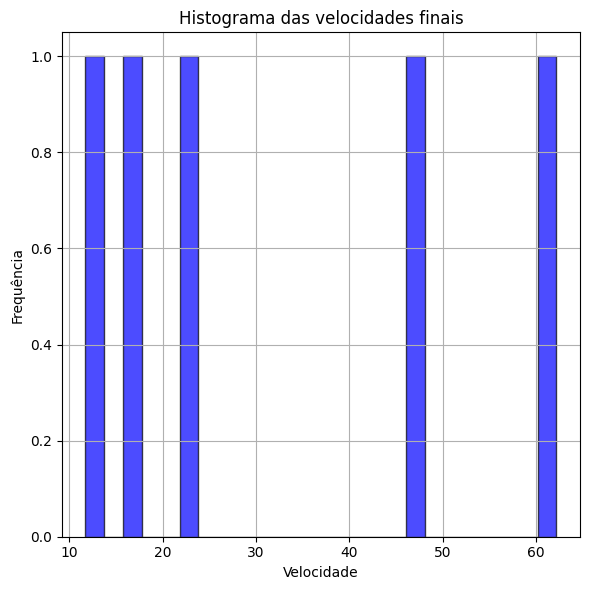

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [23]:
#Debugging 12-10-2023 == TRUE_v3; LATEST STABLE == V2
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid - logic
#Colisões e previsão funcionam + grid (inherited 6.12)
#Colisão inelástica e elástica implementada
#Colisão 'no future' mantida por causa de stuttering no pygame
#Colisão futura implementada em classe Particula
#Fazer: reação química; remoção dos reagentes implementado + minor optimizations


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 100
LARGURA_CAIXA = 100
NUM_PARTICULAS = 10
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

# Indexes de moléculas das reações
NA_CL_INDEX = 0

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite


class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=TIPO_COLISAO)

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    print('old_particles:', particles)
    #print(p1.p_type, p2.p_type)

    if (p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na'):
        print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = 5
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)

        #sprites.add(particle_instance.sprite_pygame)
        
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()



    else:
        print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    print('new_particles:',particles)
    #print()
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula

def select_particles(particles,sprites):
    particles_update = set()
    particles_remove = []

    particle_pairs = np.array(list(itertools.permutations(particles.items(), 2)))

    for (name_p1, instance_p1), (name_p2, instance_p2) in particle_pairs:
        if check_collision(instance_p1, instance_p2):
            reacted_particles = reaction_collision(particles, instance_p1, name_p1, instance_p2, name_p2,sprites)
            #print('funciona')

            if particles != reacted_particles:
                particles_update.update(reacted_particles)
                particles_remove.extend([name_p1, name_p2])

    for particle_name in particles_remove:
        del particles[particle_name]

    particles.update(particles_update)

    return particles

def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 5, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 5, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas

def select_particles(particles):
    particles_to_update = set()
    particles_to_remove = []

    particle_pairs = list(itertools.combinations(particles.items(), 2))

    for (name1, particle1), (name2, particle2) in particle_pairs:
        if check_collision(particle1, particle2):
            reacted_particles = reaction_collision(particles, particle1, name1, particle2, name2)
            print('funciona')

            if particles != reacted_particles:
                particles_to_update.update(reacted_particles)
                particles_to_remove.extend([name1, name2])

    for particle_name in particles_to_remove:
        del particles[particle_name]

    particles.update(particles_to_update)

    return particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    print(sprites)
    return sprites


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_11.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        after_reaction_particles = select_particles(particles)
        #print(type(after_reaction_particles))

        # Update particle positions after collision detection
        for particle_name, particle_instance in after_reaction_particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, after_reaction_particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()
